In [1]:
%pip install minisom -q
%pip install tensorflow -q
%pip install matplotlib -q
%pip install seaborn -q
%pip install scikit-learn -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Importar las librerias necesarias

In [2]:
from minisom import MiniSom
import numpy as np
from PIL import Image
import math

Colocar datos globales

In [3]:
LEFT_LOOP   = 0
RIGHT_LOOP  = 1
WHORL       = 2
ARCO        = 3

## Funciones necesarias

In [4]:
def sobel(I):
    """
    Aplica el operador Sobel para detectar bordes en una imagen.

    Parámetros:
    I (numpy.ndarray): Imagen de entrada en escala de grises

    Retorna:
    tuple: Un par de matrices (Gx, Gy) que contienen los gradientes en x e y
           Gx representa los bordes verticales
           Gy representa los bordes horizontales
    """

    # Obtener las dimensiones de la imagen
    m,n = I.shape# I de 254x254

    # Crear matrices para almacenar los gradientes
    Gx = np.zeros([m-2,n-2],np.float32)# Gx de 252x252
    Gy = np.zeros([m-2,n-2],np.float32)# Gy de 252x252

    # Definir los kernels de Sobel
    gx = [[-1,0,1],[ -2,0,2],[ -1,0,1]]
    gy = [[1,2,1],[ 0,0,0],[ -1,-2,-1]]

    # Recorrer la imagen y aplicar el operador Sobel
    for j in range(1,m-2):
        for i in range(1,n-2):
            Gx[j-1,i-1] = sum(sum(I[j-1:j+2,i-1:i+2]*gx))
            Gy[j-1,i-1] = sum(sum(I[j-1:j+2,i-1:i+2]*gy))

    # Devolver los gradientes calculados
    return Gx,Gy

def medfilt2(G,d=3):
    """
    Aplica un filtro de mediana a una matriz.
    Reemplaza cada píxel por la mediana de los valores de los píxeles en su vecindad.
    Es equivalente a suavizar la imagen.

    Parámetros:
    G (numpy.ndarray): Matriz de entrada
    d (int): Tamaño del filtro de mediana

    Retorna:
    numpy.ndarray: Matriz resultante después de aplicar el filtro de mediana
    """
    m,n = G.shape
    temp = np.zeros([m+2*(d//2),n+2*(d//2)],np.float32)
    salida = np.zeros([m,n],np.float32)
    temp[1:m+1,1:n+1] = G
    for i in range(1,m):
        for j in range(1,n):
            A = np.asarray(temp[i-1:i+2,j-1:j+2]).reshape(-1)
            salida[i-1,j-1] = np.sort(A)[d+1]
    return salida

def orientacion(patron,w):
    """
    Calcula la orientación de los bordes en una imagen.

    Parámetros:
    patron (numpy.ndarray): Matriz de entrada de 254x254
    w (int): Tamaño de la ventana para calcular la orientación.

    Retorna:
    numpy.ndarray: Matriz de 18x18 que contiene las orientaciones calculadas
    """
    # Aplicar el operador Sobel para detectar bordes
    Gx,Gy = sobel(patron)       # patron de 254x254

    # Aplicar un filtro de mediana para suavizar los bordes
    Gx = medfilt2(Gx)           # Gx de 252x252
    Gy = medfilt2(Gy)           # Gy de 252x252

    # Obtener las dimensiones de la matriz resultante
    m,n = Gx.shape

    # Crear una matriz para almacenar las orientaciones
    mOrientaciones = np.zeros([m//w,n//w],np.float32)   # de una matriz de 18x18

    # Recorrer la matriz y calcular las orientaciones
    for i in range(m//w):
        for j in range(n//w):
            YY = sum(sum(2*Gx[i*w:(i+1)*w,j:j+1]*Gy[i*w:(i+1)*w,j:j+1]))
            XX = sum(sum(Gx[i*w:(i+1)*w,j:j+1]**2-Gy[i*w:(i+1)*w,j:j+1]**2))
            #YY = sum(sum(2*Gx[i*w:(i+1)*w,0:1]*Gy[i*w:(i+1)*w,0:1]))
            #XX = sum(sum(Gx[i*w:(i+1)*w,0:1]**2-Gy[i*w:(i+1)*w,0:1]**2))
            mOrientaciones[i,j] = (0.5*math.atan2(YY,XX) + math.pi/2.0)*(180.0/math.pi)
    return mOrientaciones

def representativo(archivo):
    """
    Calcula el vector representativo de una huella.
    Lee una imagen de huella, la convierte a escala de grises, aplica el operador Sobel para detectar bordes,
    aplica un filtro de mediana para suavizar los bordes, y calcula la orientación de los bordes en la imagen.

    Parámetros:
    archivo (str): Ruta al archivo de imagen de la huella

    Retorna:
    numpy.ndarray: Vector de 324 elementos que representa la huella
    """
    im = Image.open(archivo)
    m,n = im.size
    imarray = np.array(im,np.float32)
    patron = imarray[1:m-1,1:n-1]# de 256x256  a 254x254
    EE = orientacion(patron,14)# retorna EE de 18x18
    return np.asarray(EE).reshape(-1)

Vamos a importar los datos

In [5]:
n_samples = 60000
Xi = np.zeros([n_samples, 784],np.float32)  # 28x28 = 784 dimensions

# Load MNIST dataset
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocessing needed:
# 1. Normalize to [0,1] range
X_train = X_train / 255.0
# 2. Reshape from (n_samples, 28, 28) to (n_samples, 784)
X_train_reshaped = X_train.reshape(X_train.shape[0], 784)[:n_samples]

# Assign to Xi
Xi = X_train_reshaped

# Assign to Yi
Yi = y_train[:n_samples]

print(Xi.shape)
print(Yi.shape)

2024-12-12 16:59:03.447115: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 16:59:03.447615: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 16:59:03.450672: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 16:59:03.458599: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734040743.472852  241052 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734040743.47

(60000, 784)
(60000,)


Usar la libreria SOM

In [6]:
max_iter = 5000
alpha_max = 0.5

som = MiniSom(x=20, y=20, input_len=784, sigma=1.0, learning_rate=alpha_max,activation_distance='euclidean',
              topology='hexagonal', neighborhood_function='gaussian')
som.random_weights_init(Xi)
som.train_random(data=Xi, num_iteration=max_iter)

In [15]:
# Crear una matriz M vacía con las mismas dimensiones que la cuadrícula de la SOM (10x10)
M = np.zeros([20, 20], np.float32) - 1  # Inicializar con -1

# Para cada muestra de entrenamiento
for i, x in enumerate(X_train_reshaped):
    # Encontrar la neurona ganadora para esta muestra
    w = som.winner(x)
    # Asignar la etiqueta verdadera a esta posición
    M[w[0], w[1]] = y_train[i]

print("Matriz de etiquetas M:")
print(M)

Matriz de etiquetas M:
[[1. 1. 1. 1. 2. 2. 2. 2. 0. 0. 5. 1. 1. 1. 5. 3. 2. 0. 0. 5.]
 [4. 1. 4. 1. 3. 3. 3. 0. 0. 0. 6. 1. 7. 7. 8. 2. 2. 2. 2. 0.]
 [5. 5. 5. 6. 5. 3. 3. 0. 0. 0. 0. 1. 2. 6. 2. 2. 2. 2. 2. 8.]
 [9. 5. 5. 5. 5. 5. 5. 0. 0. 0. 3. 5. 6. 6. 4. 2. 2. 2. 2. 8.]
 [4. 5. 4. 9. 5. 5. 6. 0. 0. 8. 6. 6. 6. 6. 6. 2. 3. 2. 2. 3.]
 [7. 9. 7. 4. 6. 6. 6. 0. 0. 6. 6. 6. 6. 6. 2. 2. 3. 3. 8. 1.]
 [7. 7. 6. 0. 0. 0. 4. 0. 9. 6. 6. 6. 6. 6. 6. 3. 3. 3. 8. 1.]
 [8. 2. 6. 6. 4. 4. 4. 4. 8. 9. 4. 6. 2. 6. 9. 3. 3. 3. 1. 1.]
 [8. 8. 8. 6. 4. 4. 9. 4. 9. 2. 9. 9. 9. 9. 4. 9. 5. 3. 1. 1.]
 [8. 8. 8. 4. 4. 4. 5. 5. 3. 8. 4. 7. 4. 4. 9. 9. 7. 3. 1. 1.]
 [8. 8. 9. 7. 4. 8. 5. 5. 3. 9. 4. 4. 4. 4. 9. 4. 9. 3. 8. 1.]
 [8. 8. 9. 9. 9. 5. 8. 5. 3. 3. 9. 2. 9. 9. 7. 9. 2. 2. 2. 2.]
 [7. 4. 8. 9. 5. 8. 8. 3. 8. 9. 4. 9. 9. 9. 9. 4. 2. 2. 2. 2.]
 [7. 7. 5. 5. 5. 8. 8. 8. 5. 4. 4. 9. 3. 9. 4. 2. 2. 2. 2. 2.]
 [7. 7. 5. 5. 8. 8. 8. 8. 3. 4. 4. 4. 9. 4. 6. 2. 2. 2. 2. 2.]
 [0. 8. 5. 5. 5. 8. 3. 3. 3. 5. 

In [16]:
# Guardar la matriz M
import pickle
with open('M_matrix.pkl', 'wb') as f:
    pickle.dump(M, f)
print("M guardada en M_matrix.pkl")

M guardada en M_matrix.pkl


Visualizar los datos en la matriz index

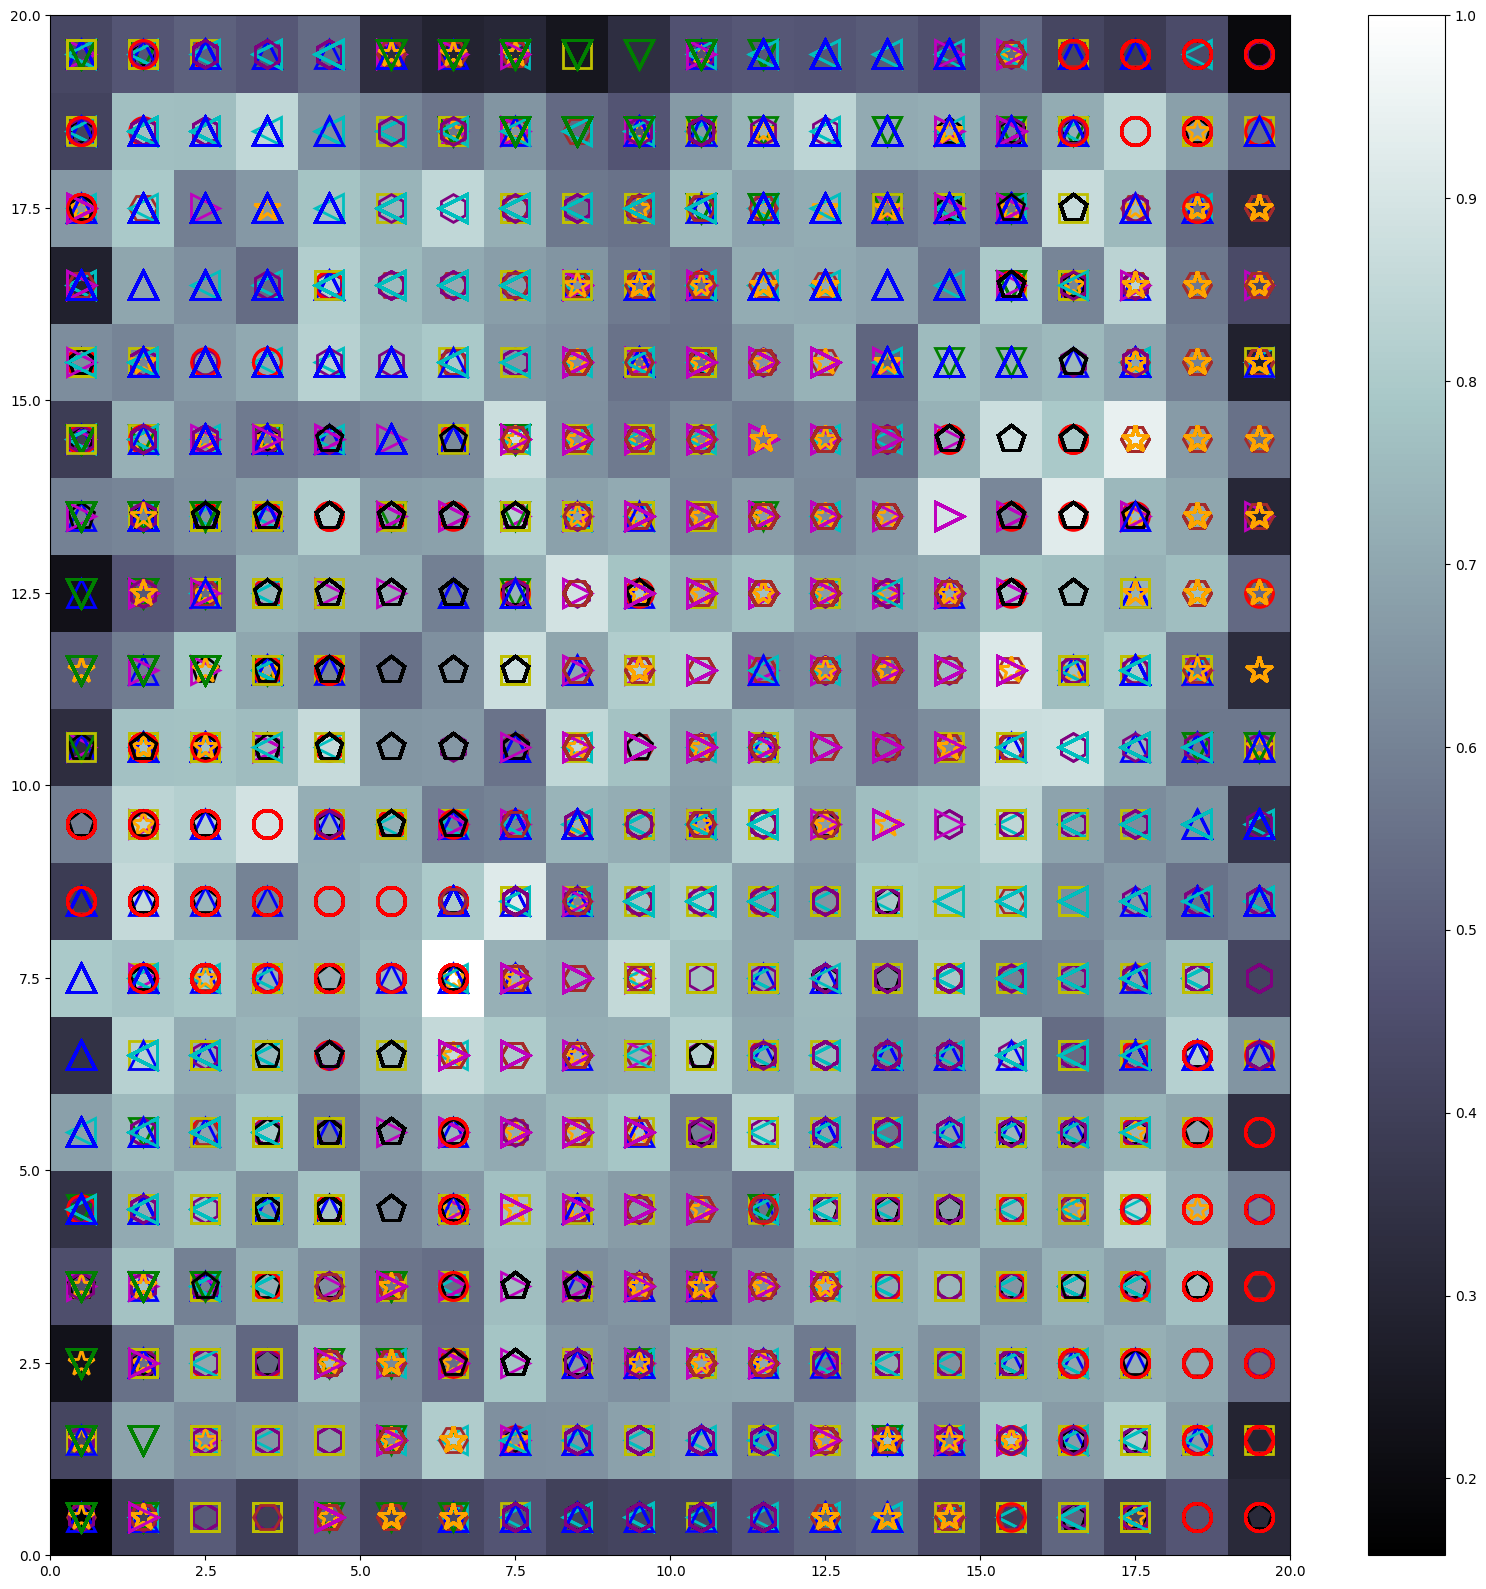

In [7]:
from pylab import bone, pcolor, colorbar, plot, show
from pylab import rcParams

# Configurar el tamaño de la figura
rcParams['figure.figsize'] = 20, 20

# Inicializar la figura
bone()

# Visualizar la matriz de distancias
pcolor(som.distance_map().T)

# Mostrar la barra de colores
colorbar()

# Crear una matriz para almacenar las etiquetas
valores = [0,1,2,3,4,5,6,7,8,9]
M = np.zeros([20,20],np.float32)-1
markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H']  # 10 markers
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']  # 10 colors

# Recorrer los datos y asignar las etiquetas
for i, x in enumerate(Xi):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[Yi[i]],
         markeredgecolor=colors[Yi[i]],
         markerfacecolor='None',
         markersize=20,
         markeredgewidth=2)
    M[w[0],w[1]] = Yi[i]
show()

## Guardar la matriz M

In [8]:
import pickle
with open('som_mnist.pkl', 'wb') as outfile:
    pickle.dump(som, outfile)

La comprobacion a partir de la matriz M

In [9]:
#  Preparar los datos de prueba (normalizar como lo hicimos con los datos de entrenamiento)
X_test = X_test / 255.0
X_test_reshaped = X_test.reshape(X_test.shape[0], 784)

# Crear un array de predicciones para los datos de prueba
Y_test_predicted = []

# Obtener las predicciones para los datos de prueba
for i in range(len(X_test_reshaped)):
    # Encontrar el ganador para cada muestra de prueba
    w = som.winner(X_test_reshaped[i])
    # Obtener la clase predicha basada en el ganador de la neurona
    Y_test_predicted.append(M[w])

# Convertir las predicciones a un array numpy
Y_test_predicted = np.array(Y_test_predicted)

# Calcular y mostrar métricas
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("Reporte de Clasificación para Datos de Prueba:")
print(classification_report(y_test, Y_test_predicted))


Reporte de Clasificación para Datos de Prueba:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       980
           1       0.97      0.96      0.96      1135
           2       0.89      0.89      0.89      1032
           3       0.82      0.82      0.82      1010
           4       0.80      0.72      0.76       982
           5       0.72      0.83      0.77       892
           6       0.92      0.90      0.91       958
           7       0.86      0.78      0.82      1028
           8       0.82      0.76      0.79       974
           9       0.69      0.74      0.71      1009

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.83     10000
weighted avg       0.84      0.84      0.84     10000



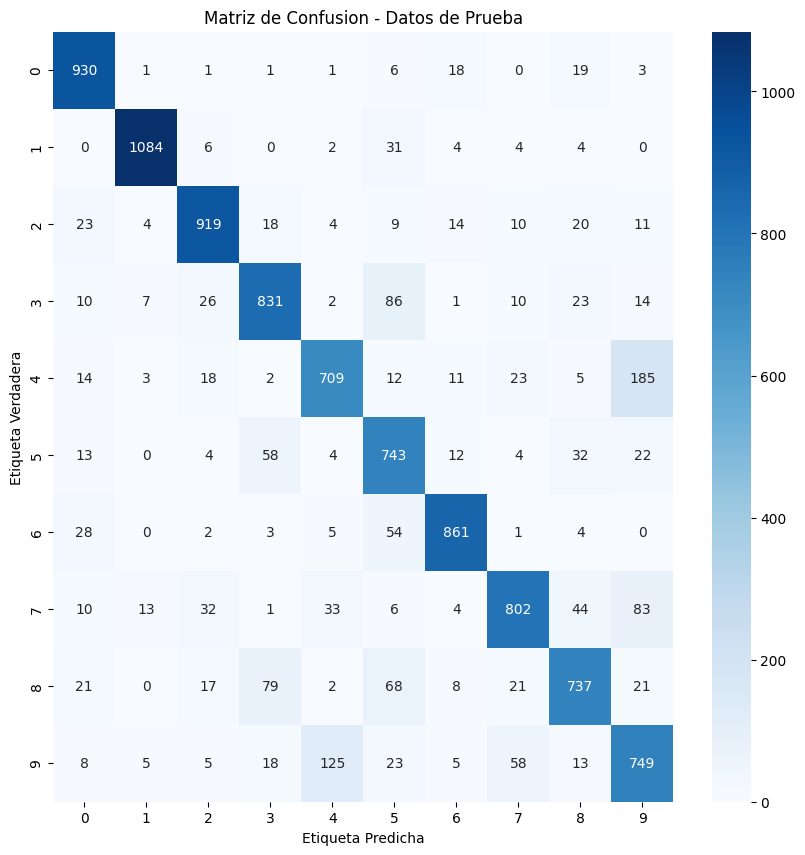


Exactitud General en Datos de Prueba: 83.65%


In [10]:
import matplotlib.pyplot as plt

# Create and plot confusion matrix
plt.figure(figsize=(10,10))
cm = confusion_matrix(y_test, Y_test_predicted)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusion - Datos de Prueba')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.show()

# Calculate overall accuracy
accuracy = np.mean(Y_test_predicted == y_test)
print(f"\nExactitud General en Datos de Prueba: {accuracy*100:.2f}%")

Leer la red som desde un archivo

In [11]:
with open('som_mnist.pkl', 'rb') as infile:
    som = pickle.load(infile)


### Abrir lo aprendido

In [12]:
with open("som_mnist.pkl", "rb") as tf:
    som_cargado = pickle.load(tf)

B = X_test_reshaped[-1]
w = som_cargado.winner(B)
print(w)
print(M[w])#


(6, 11)
6.0


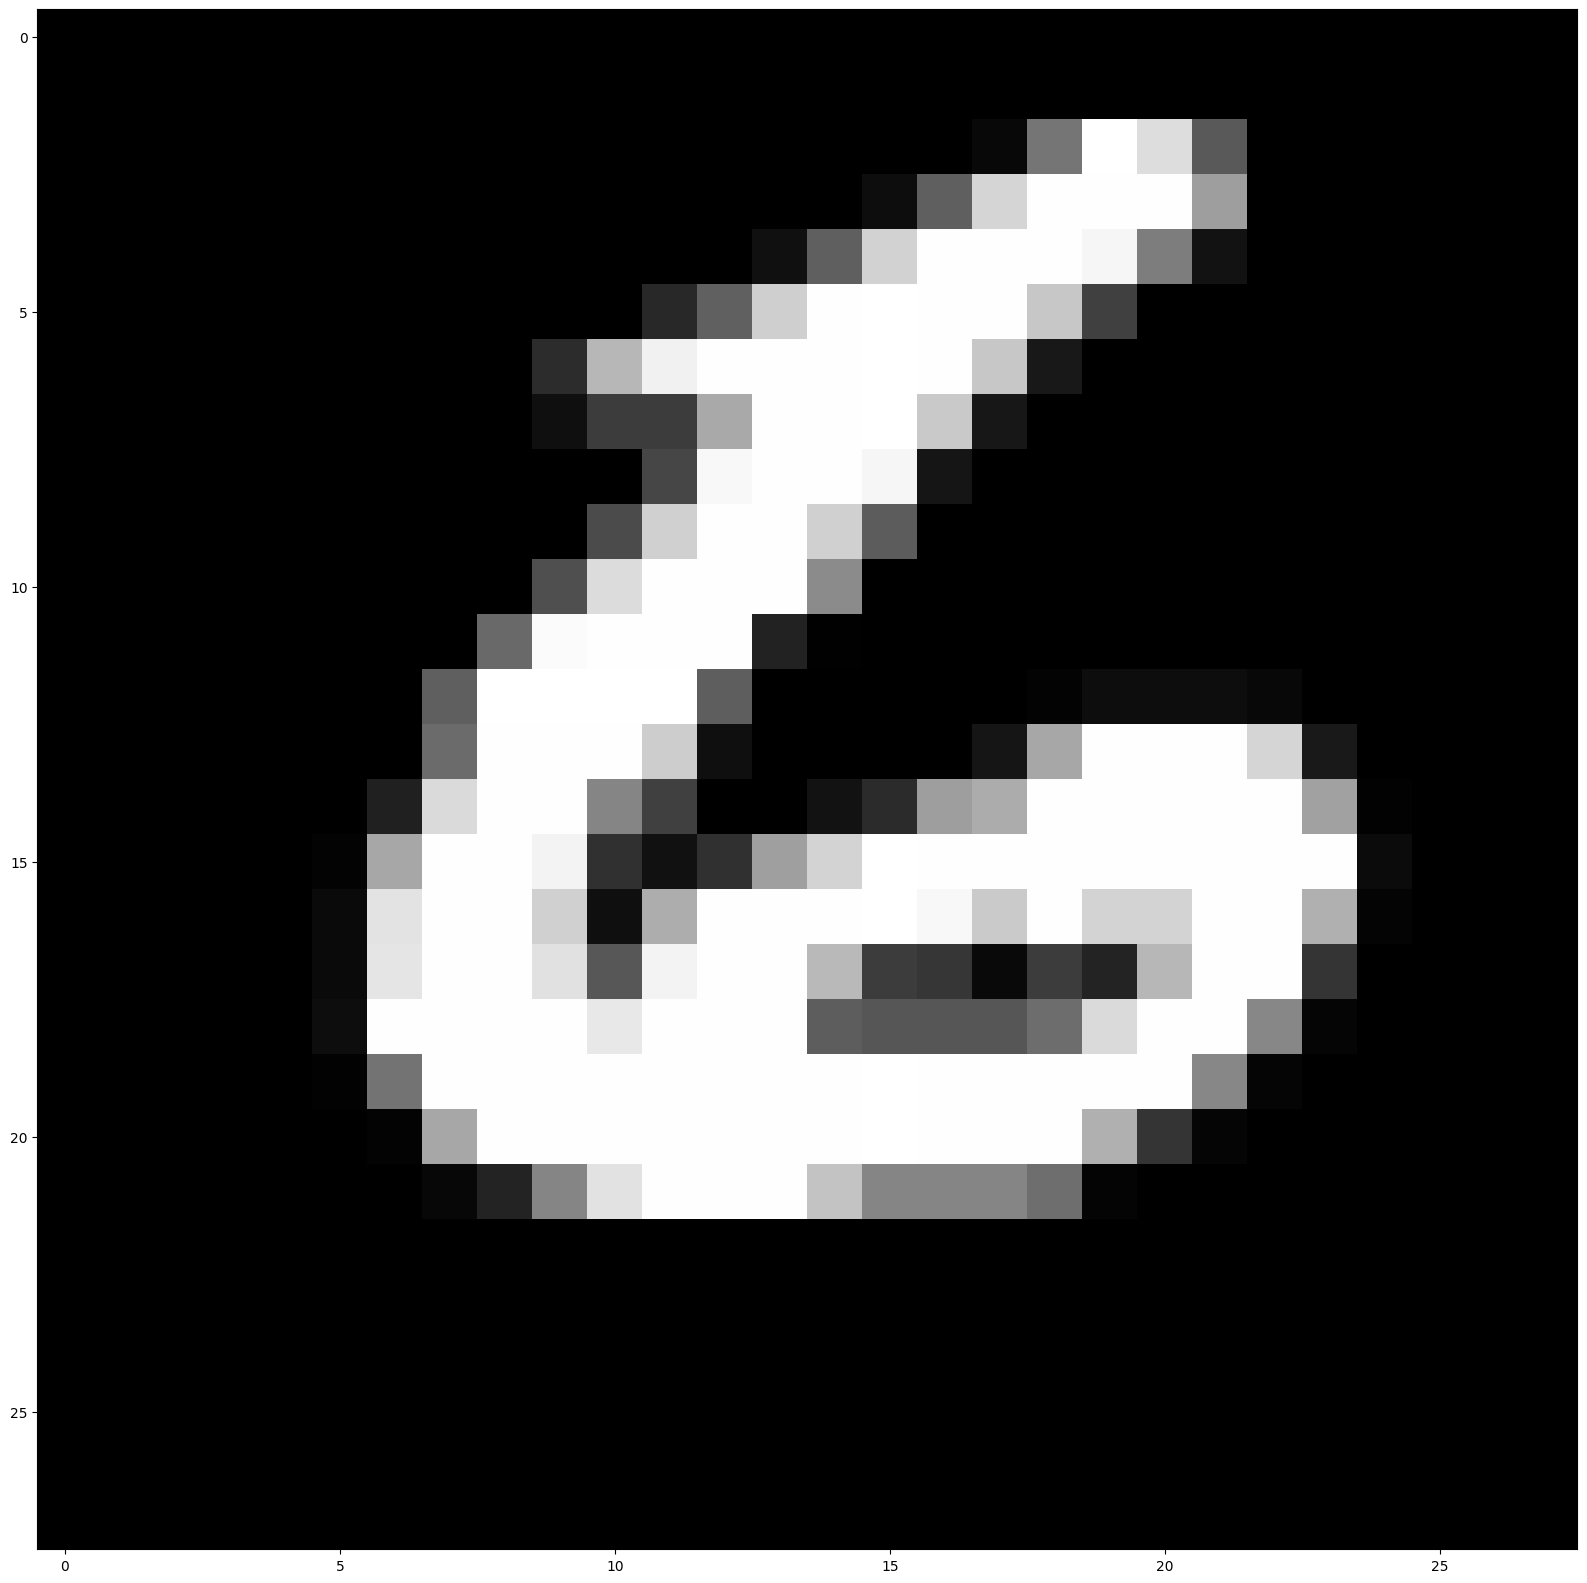

In [13]:
# Visualizar la imagen
plt.imshow(B.reshape(28, 28), cmap='gray')
plt.show()